In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, svm, neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import svm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


In [3]:
# 
selectedFeatures = [  
    'AVProductStatesIdentifier'
    ,'AVProductsEnabled'
    ,'IsProtected'
    ,'Processor'
    ,'OsSuite'
    ,'IsProtected'
    ,'RtpStateBitfield'
    ,'AVProductsInstalled'
    ,'Wdft_IsGamer'
    ,'DefaultBrowsersIdentifier'
    ,'OsBuild'
    ,'Wdft_RegionIdentifier'
    ,'SmartScreen'
    ,'CityIdentifier'
    ,'AppVersion'
    ,'Census_IsSecureBootEnabled'
    ,'Census_PrimaryDiskTypeName'
    ,'Census_SystemVolumeTotalCapacity'
    ,'Census_HasOpticalDiskDrive'
    ,'Census_IsWIMBootEnabled'
    ,'Census_IsVirtualDevice'
    ,'Census_IsTouchEnabled'
    ,'Census_FirmwareVersionIdentifier'
    ,'GeoNameIdentifier'
    ,'IeVerIdentifier'
    ,'Census_FirmwareManufacturerIdentifier'
    ,'Census_InternalPrimaryDisplayResolutionHorizontal'
    ,'Census_InternalPrimaryDisplayResolutionVertical'
    ,'Census_OEMModelIdentifier'
    ,'Census_ProcessorModelIdentifier'
    ,'Census_OSVersion'
    ,'Census_InternalPrimaryDiagonalDisplaySizeInInches'
    ,'Census_OEMNameIdentifier'
    ,'Census_ChassisTypeName'
    ,'Census_OSInstallLanguageIdentifier'
    ,'EngineVersion'
    ,'OrganizationIdentifier' 
    ,'CountryIdentifier'   
    ,'Census_ActivationChannel'
    ,'Census_ProcessorCoreCount'
    ,'Census_OSWUAutoUpdateOptionsName'
    ,'Census_InternalBatteryType'
    ]

In [5]:
import random
numberOfRows = 1000000

seed = 6001
np.random.seed(seed)
random.seed(seed)

In [6]:
# Load train and test files
train_file=pd.read_csv("../input/train.csv", sep=",", usecols = selectedFeatures+['HasDetections'], low_memory=True, nrows = numberOfRows)
test_file=pd.read_csv("../input/test.csv", sep=",", usecols = selectedFeatures, low_memory=True, nrows = numberOfRows)

In [7]:
print('Train : ' + str(train_file.shape))
print('Test : ' + str(test_file.shape))

Train : (1000000, 42)
Test : (1000000, 41)


In [8]:
# Check if the data contains null values
train_file.isna().sum()

EngineVersion                                             0
AppVersion                                                0
RtpStateBitfield                                       3666
DefaultBrowsersIdentifier                            951697
AVProductStatesIdentifier                              4093
AVProductsInstalled                                    4093
AVProductsEnabled                                      4093
CountryIdentifier                                         0
CityIdentifier                                        36513
OrganizationIdentifier                               308936
GeoNameIdentifier                                        19
Processor                                                 0
OsBuild                                                   0
OsSuite                                                   0
IsProtected                                            4076
IeVerIdentifier                                        6653
SmartScreen                             

In [9]:
df = pd.DataFrame(train_file)
df_test = pd.DataFrame(test_file)

# Drop the columns which have large amount of null values. For e.g. DefaultBrowsersIdentifier has more 900000 null values. 
# Filling it with mean or 0 will bias our model

df= df.drop(['DefaultBrowsersIdentifier', 'Census_InternalBatteryType','Census_IsWIMBootEnabled'], axis=1)
df.dtypes

EngineVersion                                         object
AppVersion                                            object
RtpStateBitfield                                     float64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier                                    float64
Processor                                             object
OsBuild                                                int64
OsSuite                                                int64
IsProtected                                          float64
IeVerIdentifier                                      float64
SmartScreen                                           object
Census_OEMNameIdentifier

In [10]:
# Drop all the Nan data rows
df = df.dropna()
df.describe()

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,OsBuild,OsSuite,IsProtected,IeVerIdentifier,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_OSInstallLanguageIdentifier,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,4.021690e+05,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000
mean,6.831233,47232.463805,1.385291,1.027700,106.850724,80885.433494,24.862476,167.844118,15422.829810,602.127126,0.939309,123.082227,2198.964189,235549.656515,3.747862,2318.464499,3.892948e+05,0.095940,16.295252,1517.055974,877.083701,14.304556,413.337736,33530.585239,0.533144,0.001574,0.140779,0.243970,8.235195,0.513913
std,1.063544,14688.808269,0.549087,0.189247,63.073323,49126.881616,5.375048,89.423060,2274.038745,239.610784,0.238763,44.579244,1304.300656,73362.389469,1.681793,859.230458,3.203254e+05,0.294509,5.578068,333.477746,198.734431,10.208362,221.885359,21051.350845,0.498901,0.039642,0.347794,0.429475,4.452466,0.499807
min,0.000000,6.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,7600.000000,256.000000,0.000000,1.000000,2.000000,23.000000,1.000000,19.000000,0.000000e+00,0.000000,4.900000,320.000000,240.000000,1.000000,17.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.000000,47238.000000,1.000000,1.000000,50.000000,34983.000000,18.000000,89.000000,14393.000000,256.000000,1.000000,107.000000,1443.000000,189533.000000,2.000000,1992.000000,1.209730e+05,0.000000,13.900000,1366.000000,768.000000,8.000000,142.000000,14741.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
50%,7.000000,53447.000000,1.000000,1.000000,94.000000,82373.000000,27.000000,167.000000,16299.000000,768.000000,1.000000,117.000000,2102.000000,244755.000000,4.000000,2407.000000,3.016960e+05,0.000000,15.500000,1366.000000,768.000000,9.000000,500.000000,33070.000000,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,7.000000,53447.000000,2.000000,1.000000,160.000000,124631.000000,27.000000,258.000000,17134.000000,768.000000,1.000000,137.000000,2668.000000,299393.000000,4.000000,2746.000000,4.759660e+05,0.000000,16.300000,1600.000000,1024.000000,20.000000,556.000000,52570.000000,1.000000,0.000000,0.000000,0.000000,11.000000,1.000000
max,8.000000,70492.000000,5.000000,4.000000,222.000000,167962.000000,52.000000,295.000000,18237.000000,784.000000,1.000000,395.000000,6144.000000,345494.000000,88.000000,4472.000000,9.536968e+06,1.000000,142.000000,11520.000000,8640.000000,39.000000,1087.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


In [11]:
labels = pd.DataFrame(df['HasDetections'])
print('Labels : ' + str(labels.shape))
df = df.drop(['HasDetections'], axis =1)
print('Train : ' + str(df.shape))

Labels : (402169, 1)
Train : (402169, 38)


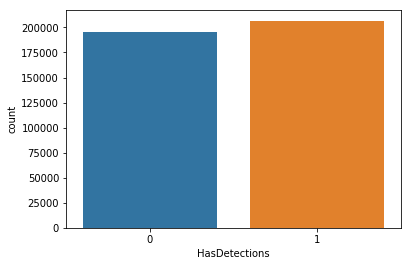

In [12]:
# Check count of the labels
import seaborn as sns
ax = sns.countplot(x="HasDetections", data=labels)

In [13]:
df.describe()

,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,OsBuild,OsSuite,IsProtected,IeVerIdentifier,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_OSInstallLanguageIdentifier,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier
count,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,4.021690e+05,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000,402169.000000
mean,6.831233,47232.463805,1.385291,1.027700,106.850724,80885.433494,24.862476,167.844118,15422.829810,602.127126,0.939309,123.082227,2198.964189,235549.656515,3.747862,2318.464499,3.892948e+05,0.095940,16.295252,1517.055974,877.083701,14.304556,413.337736,33530.585239,0.533144,0.001574,0.140779,0.243970,8.235195
std,1.063544,14688.808269,0.549087,0.189247,63.073323,49126.881616,5.375048,89.423060,2274.038745,239.610784,0.238763,44.579244,1304.300656,73362.389469,1.681793,859.230458,3.203254e+05,0.294509,5.578068,333.477746,198.734431,10.208362,221.885359,21051.350845,0.498901,0.039642,0.347794,0.429475,4.452466
min,0.000000,6.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,7600.000000,256.000000,0.000000,1.000000,2.000000,23.000000,1.000000,19.000000,0.000000e+00,0.000000,4.900000,320.000000,240.000000,1.000000,17.000000,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.000000,47238.000000,1.000000,1.000000,50.000000,34983.000000,18.000000,89.000000,14393.000000,256.000000,1.000000,107.000000,1443.000000,189533.000000,2.000000,1992.000000,1.209730e+05,0.000000,13.900000,1366.000000,768.000000,8.000000,142.000000,14741.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,7.000000,53447.000000,1.000000,1.000000,94.000000,82373.000000,27.000000,167.000000,16299.000000,768.000000,1.000000,117.000000,2102.000000,244755.000000,4.000000,2407.000000,3.016960e+05,0.000000,15.500000,1366.000000,768.000000,9.000000,500.000000,33070.000000,1.000000,0.000000,0.000000,0.000000,10.000000
75%,7.000000,53447.000000,2.000000,1.000000,160.000000,124631.000000,27.000000,258.000000,17134.000000,768.000000,1.000000,137.000000,2668.000000,299393.000000,4.000000,2746.000000,4.759660e+05,0.000000,16.300000,1600.000000,1024.000000,20.000000,556.000000,52570.000000,1.000000,0.000000,0.000000,0.000000,11.000000
max,8.000000,70492.000000,5.000000,4.000000,222.000000,167962.000000,52.000000,295.000000,18237.000000,784.000000,1.000000,395.000000,6144.000000,345494.000000,88.000000,4472.000000,9.536968e+06,1.000000,142.000000,11520.000000,8640.000000,39.000000,1087.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,15.000000


In [14]:
# Tune SmartScreen feature

df.loc[df.SmartScreen == 'off', 'SmartScreen']= 'Off'
df.loc[df.SmartScreen == 'of', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'OFF', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == '00000000', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == '0', 'SmartScreen'] = 'Off'       
df.loc[df.SmartScreen == 'ON', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'on', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'Enabled', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'BLOCK', 'SmartScreen'] = 'Block'
df.loc[df.SmartScreen == 'requireadmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'requireAdmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'RequiredAdmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'Promt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'Promprt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'prompt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'warn', 'SmartScreen'] = 'Warn'
df.loc[df.SmartScreen == 'Deny', 'SmartScreen'] = 'Block'
df.loc[df.SmartScreen == '&#x03;', 'SmartScreen'] = 'Off'

In [15]:
df_test.loc[df_test.SmartScreen == 'off', 'SmartScreen'] = 'Off'
df_test.loc[df_test.SmartScreen == 'of', 'SmartScreen'] = 'Off'
df_test.loc[df_test.SmartScreen == 'OFF', 'SmartScreen'] = 'Off'
df_test.loc[df_test.SmartScreen == '00000000', 'SmartScreen'] = 'Off'
df_test.loc[df_test.SmartScreen == '0', 'SmartScreen'] = 'Off'       
df_test.loc[df_test.SmartScreen == 'ON', 'SmartScreen'] = 'On'
df_test.loc[df_test.SmartScreen == 'on', 'SmartScreen'] = 'On'
df_test.loc[df_test.SmartScreen == 'Enabled', 'SmartScreen'] = 'On'
df_test.loc[df_test.SmartScreen == 'BLOCK', 'SmartScreen'] = 'Block'
df_test.loc[df_test.SmartScreen == 'requireadmin', 'SmartScreen'] = 'RequireAdmin'
df_test.loc[df_test.SmartScreen == 'requireAdmin', 'SmartScreen'] = 'RequireAdmin'
df_test.loc[df_test.SmartScreen == 'RequiredAdmin', 'SmartScreen'] = 'RequireAdmin'
df_test.loc[df_test.SmartScreen == 'Promt', 'SmartScreen'] = 'Prompt'
df_test.loc[df_test.SmartScreen == 'Promprt', 'SmartScreen'] = 'Prompt'
df_test.loc[df_test.SmartScreen == 'prompt', 'SmartScreen'] = 'Prompt'
df_test.loc[df_test.SmartScreen == 'warn', 'SmartScreen'] = 'Warn'
df_test.loc[df_test.SmartScreen == 'Deny', 'SmartScreen'] = 'Block'
df_test.loc[df_test.SmartScreen == '&#x03;', 'SmartScreen'] = 'Off'


In [16]:
# Create dummy variables

dfDummy = pd.get_dummies(df, dummy_na=True)
print('Dummy: ' + str(dfDummy.shape))

Dummy: (402169, 518)


In [17]:
train = dfDummy[:numberOfRows]
test = dfDummy[numberOfRows:]
print('== Dataset Columns ==')
features = [f for f in train.columns if f not in ['index']]
for feature in features:
    print(feature)

== Dataset Columns ==
RtpStateBitfield
AVProductStatesIdentifier
AVProductsInstalled
AVProductsEnabled
CountryIdentifier
CityIdentifier
OrganizationIdentifier
GeoNameIdentifier
OsBuild
OsSuite
IsProtected
IeVerIdentifier
Census_OEMNameIdentifier
Census_OEMModelIdentifier
Census_ProcessorCoreCount
Census_ProcessorModelIdentifier
Census_SystemVolumeTotalCapacity
Census_HasOpticalDiskDrive
Census_InternalPrimaryDiagonalDisplaySizeInInches
Census_InternalPrimaryDisplayResolutionHorizontal
Census_InternalPrimaryDisplayResolutionVertical
Census_OSInstallLanguageIdentifier
Census_FirmwareManufacturerIdentifier
Census_FirmwareVersionIdentifier
Census_IsSecureBootEnabled
Census_IsVirtualDevice
Census_IsTouchEnabled
Wdft_IsGamer
Wdft_RegionIdentifier
EngineVersion_1.1.11400.0
EngineVersion_1.1.11701.0
EngineVersion_1.1.11903.0
EngineVersion_1.1.12002.0
EngineVersion_1.1.12101.0
EngineVersion_1.1.12205.0
EngineVersion_1.1.12300.0
EngineVersion_1.1.12400.0
EngineVersion_1.1.12804.0
EngineVersion_1

In [19]:
oofPreds = np.zeros(train.shape[0])
subPreds = np.zeros(test.shape[0])
featureImportanceDf = pd.DataFrame()

In [20]:
# Train LightGBM Classifier with StratifiedKFold to improve training model

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)
for n_fold, (trainXId, validXId) in enumerate(folds.split(train[features], labels)):
    # Create TrainXY and ValidationXY set based on fold-indexes
    trainX, trainY = train[features].iloc[trainXId], labels.iloc[trainXId]
    validX, validY = train[features].iloc[validXId], labels.iloc[validXId]

    print('== Fold: ' + str(n_fold))

    # LightGBM parameters
    lgbm = LGBMClassifier(
        objective = 'binary',
        boosting_type = 'gbdt',
        n_estimators = 2500,
        learning_rate = 0.05, 
        num_leaves = 250,
        min_data_in_leaf = 125, 
        bagging_fraction = 0.901,
        max_depth = 13, 
        reg_alpha = 2.5,
        reg_lambda = 2.5,
        min_split_gain = 0.0001,
        min_child_weight = 25,
        feature_fraction = 0.5, 
        silent = -1,
        verbose = -1,
        n_jobs = -1) 

    lgbm.fit(trainX, trainY, 
        eval_set=[(trainX, trainY), (validX, validY)], 
        eval_metric = 'auc', 
        verbose = 250, 
        early_stopping_rounds = 5)

    oofPreds[validXId] = lgbm.predict_proba(validX, num_iteration = lgbm.best_iteration_)[:, 1]
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(validY, oofPreds[validXId])))
          

== Fold: 0


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 5 rounds.
[250]	training's auc: 0.780491	training's binary_logloss: 0.56508	valid_1's auc: 0.739043	valid_1's binary_logloss: 0.59492
Early stopping, best iteration is:
[305]	training's auc: 0.787364	training's binary_logloss: 0.559563	valid_1's auc: 0.739489	valid_1's binary_logloss: 0.594474
Fold  1 AUC : 0.739489
== Fold: 1


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 5 rounds.
[250]	training's auc: 0.781221	training's binary_logloss: 0.564362	valid_1's auc: 0.739443	valid_1's binary_logloss: 0.595264
Early stopping, best iteration is:
[277]	training's auc: 0.785027	training's binary_logloss: 0.561301	valid_1's auc: 0.739835	valid_1's binary_logloss: 0.594927
Fold  2 AUC : 0.739835
== Fold: 2


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 5 rounds.
[250]	training's auc: 0.780749	training's binary_logloss: 0.564524	valid_1's auc: 0.737528	valid_1's binary_logloss: 0.596341
Early stopping, best iteration is:
[255]	training's auc: 0.781419	training's binary_logloss: 0.563991	valid_1's auc: 0.737604	valid_1's binary_logloss: 0.596286
Fold  3 AUC : 0.737604
== Fold: 3


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 5 rounds.
[250]	training's auc: 0.780832	training's binary_logloss: 0.564455	valid_1's auc: 0.734535	valid_1's binary_logloss: 0.598842
Early stopping, best iteration is:
[348]	training's auc: 0.792487	training's binary_logloss: 0.555034	valid_1's auc: 0.735274	valid_1's binary_logloss: 0.598242
Fold  4 AUC : 0.735274
== Fold: 4


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 5 rounds.
[250]	training's auc: 0.781523	training's binary_logloss: 0.564045	valid_1's auc: 0.738945	valid_1's binary_logloss: 0.595772
Early stopping, best iteration is:
[260]	training's auc: 0.782554	training's binary_logloss: 0.563176	valid_1's auc: 0.739033	valid_1's binary_logloss: 0.595688
Fold  5 AUC : 0.739033
